# Named Entity Recognition on BC5CDR (Chemical + Disease Corpus) with BERT


Setting Up the environment

In [1]:
!pip install -q transformers
!pip install -q simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 105.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.1/302.1 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 2

Getting data

In [18]:
import urllib.request
from pathlib import Path

def download_file(url, output_file):
  Path(output_file).parent.mkdir(parents=True, exist_ok=True)
  urllib.request.urlretrieve (url, output_file)

download_file('https://raw.githubusercontent.com/PierreZweigenbaum/bc5cdr-ner/main/BC5CDR-IOB/train.tsv', '/content/data/train.tsv')
download_file('https://raw.githubusercontent.com/PierreZweigenbaum/bc5cdr-ner/main/BC5CDR-IOB/test.tsv', '/content/data/test.tsv')
download_file('https://raw.githubusercontent.com/PierreZweigenbaum/bc5cdr-ner/main/BC5CDR-IOB/devel.tsv', '/content/data/dev.tsv')

In [21]:
import pandas as pd
def read_conll(filename):
    df = pd.read_csv(filename,
                    sep = '\t', header = None, keep_default_na = False,
                    names = ['words', 'labels'],
                    quoting = 3, skip_blank_lines = False)
    df = df[~df['words'].astype(str).str.startswith('-DOCSTART- ')] # Remove the -DOCSTART- header
    df['sentence_id'] = (df.words == '').cumsum()
    return df[df.words != '']

In [22]:
train_df = read_conll('/content/data/train.tsv')
test_df = read_conll('/content/data/test.tsv')
dev_df = read_conll('/content/data/dev.tsv')
train_df.head(100)

,words,labels,sentence_id
0,Selegiline,B-Chemical,0
1,-,O,0
2,induced,O,0
3,postural,B-Disease,0
4,hypotension,I-Disease,0
...,...,...,...
97,of,O,2
98,selegiline,B-Chemical,2
99,.,O,2
101,This,O,3


In [23]:
data = [[train_df['sentence_id'].nunique(), test_df['sentence_id'].nunique(), dev_df['sentence_id'].nunique()]]

# Prints out the dataset sizes of train and test sets per label.
pd.DataFrame(data, columns=["Train", "Test", "Dev"])

,Train,Test,Dev
0,4560,4797,4581


Training and Testing the model

In [24]:
train_args = {
    'reprocess_input_data': True,
    'overwrite_output_dir': True,
    'sliding_window': True,
    'max_seq_length': 64,
    'num_train_epochs': 10,
    'train_batch_size': 32,
    'fp16': True,
    'output_dir': '/outputs1/',
    'best_model_dir': '/outputs1/best_model/',
    'evaluate_during_training': True,
    'use_cuda': True  # Set this to False if CUDA is not available

}
#'use_cuda': False  # Set this to False if CUDA is not available

In [25]:
custom_labels = list(train_df['labels'].unique())
print(custom_labels)

['B-Chemical', 'O', 'B-Disease', 'I-Disease', 'I-Chemical']


In [26]:
from simpletransformers.ner import NERModel
from transformers import AutoTokenizer
import pandas as pd
import logging

logging.basicConfig(level=logging.DEBUG)
transformers_logger = logging.getLogger('transformers')
transformers_logger.setLevel(logging.WARNING)

# We use the BERT pre-trained model.
model = NERModel('bert', 'bert-base-uncased', labels=custom_labels, args=train_args)
output_dir_current = 'content/drive/MyDrive/outputs1/'
# Train the model
# https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
model.train_model(train_df, eval_data=dev_df)
# Save the model state
model.save_model(
    output_dir_current
)

# Evaluate the model in terms of accuracy score
result, model_outputs, preds_list = model.eval_model(test_df)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/46 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/46 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/46 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/46 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/46 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/46 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/46 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/46 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/46 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/48 [00:00<?, ?it/s]

Got an F1 score of 0.8460

Inference

In [28]:
sample = test_df[test_df.sentence_id == 10].words.str.cat(sep=' ')
print(sample)

Risk of transient hyperammonemic encephalopathy in cancer patients who received continuous infusion of 5 - fluorouracil with the complication of dehydration and infection .


In [29]:
samples = [sample]
predictions, _ = model.predict(samples)
for idx, sample in enumerate(samples):
  print('{}: '.format(idx))
  for word in predictions[idx]:
    print('{}'.format(word))

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

0: 
{'Risk': 'O'}
{'of': 'O'}
{'transient': 'O'}
{'hyperammonemic': 'B-Disease'}
{'encephalopathy': 'B-Disease'}
{'in': 'O'}
{'cancer': 'B-Disease'}
{'patients': 'O'}
{'who': 'O'}
{'received': 'O'}
{'continuous': 'O'}
{'infusion': 'O'}
{'of': 'O'}
{'5': 'B-Chemical'}
{'-': 'I-Chemical'}
{'fluorouracil': 'I-Chemical'}
{'with': 'O'}
{'the': 'O'}
{'complication': 'O'}
{'of': 'O'}
{'dehydration': 'B-Disease'}
{'and': 'O'}
{'infection': 'B-Disease'}
{'.': 'O'}


In [30]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [31]:
import shutil
shutil.move('/outputs1/', "/content/drive/MyDrive/outputs1/")

'/content/drive/MyDrive/outputs1/'

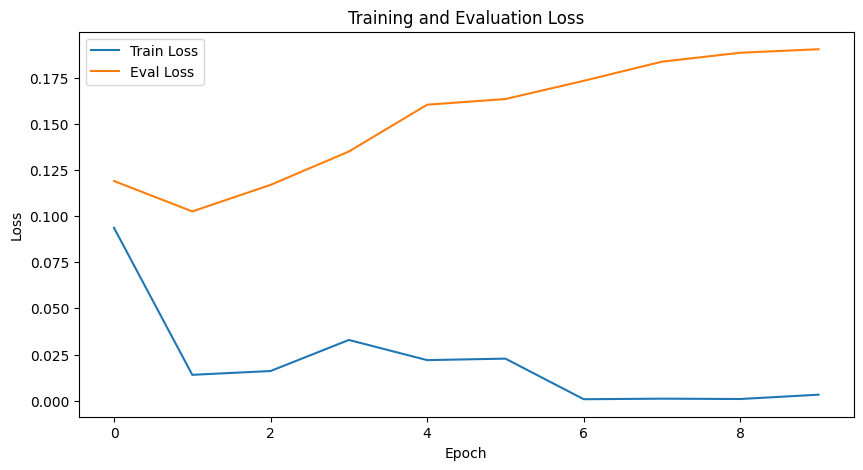

In [38]:
import matplotlib.pyplot as plt
# Read training and evaluation loss from training_progress_scores.csv
output_dir_current = '/content/drive/MyDrive/outputs1'
progress_scores = pd.read_csv("/content/drive/MyDrive/outputs1/training_progress_scores.csv")
train_loss = progress_scores['train_loss'].tolist()
eval_loss = progress_scores['eval_loss'].tolist()
epochs = range(len(train_loss))

# Plot training and evaluation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, eval_loss, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.show()


RELATION EXTRACTION

In [40]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

# Function to read CoNLL formatted file into a DataFrame
def read_conll(file_path):
    data = []
    with open(file_path, 'r') as file:
        sentence_id = 0
        for line in file:
            if line.startswith('-DOCSTART-') or line == "\n":
                sentence_id += 1
                continue
            splits = line.strip().split()
            if splits:
                word = splits[0]
                label = splits[-1]
                data.append((sentence_id, word, label))
    return pd.DataFrame(data, columns=['sentence_id', 'words', 'labels'])

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/outputs1/best_model")
model = AutoModelForTokenClassification.from_pretrained("/content/drive/MyDrive/outputs1/best_model")

# Read the test data
test_df = read_conll('/content/data/test.tsv')

# Process each sentence in the test data
sentence_id = 1  # Example: process sentence with id 1
sentence_words = test_df[test_df.sentence_id == sentence_id].words.tolist()
labels = test_df[test_df.sentence_id == sentence_id].labels.tolist()

# Tokenize the input text
inputs = tokenizer(sentence_words, return_tensors="pt", truncation=True, padding=True, is_split_into_words=True)
word_ids = inputs.word_ids()

# Get model predictions
outputs = model(**inputs)

# Process the predictions to extract entities and their relationships
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
predictions = torch.argmax(outputs.logits, dim=2)[0].numpy()

# Map token predictions to entities
entities = []
for i, word_id in enumerate(word_ids):
    if word_id is not None:  # Skip special tokens
        label = model.config.id2label[predictions[i]]
        if label != "O":
            entities.append((sentence_words[word_id], label))

# Print the sample text
print(f"Sample sentence: {' '.join(sentence_words)}")

# Print extracted entities and relationships
print("Entities and Relationships:")
for entity in entities:
    print(entity)


Sample sentence: The authors describe the case of a 56 - year - old woman with chronic , severe heart failure secondary to dilated cardiomyopathy and absence of significant ventricular arrhythmias who developed QT prolongation and torsade de pointes ventricular tachycardia during one cycle of intermittent low dose ( 2 . 5 mcg / kg per min ) dobutamine .
Entities and Relationships:
('heart', 'B-Disease')
('failure', 'I-Disease')
('dilated', 'B-Disease')
('dilated', 'I-Disease')
('cardiomyopathy', 'I-Disease')
('cardiomyopathy', 'I-Disease')
('cardiomyopathy', 'I-Disease')
('cardiomyopathy', 'I-Disease')
('ventricular', 'B-Disease')
('ventricular', 'I-Disease')
('ventricular', 'I-Disease')
('arrhythmias', 'I-Disease')
('arrhythmias', 'I-Disease')
('arrhythmias', 'I-Disease')
('arrhythmias', 'I-Disease')
('arrhythmias', 'I-Disease')
('prolongation', 'I-Disease')
('prolongation', 'I-Disease')
('prolongation', 'I-Disease')
('torsade', 'B-Disease')
('torsade', 'I-Disease')
('de', 'I-Disease'

In [41]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

# Function to read CoNLL formatted file into a DataFrame
def read_conll(file_path):
    data = []
    with open(file_path, 'r') as file:
        sentence_id = 0
        for line in file:
            if line.startswith('-DOCSTART-') or line == "\n":
                sentence_id += 1
                continue
            splits = line.strip().split()
            if splits:
                word = splits[0]
                label = splits[-1]
                data.append((sentence_id, word, label))
    return pd.DataFrame(data, columns=['sentence_id', 'words', 'labels'])

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/outputs1/best_model")
model = AutoModelForTokenClassification.from_pretrained("/content/drive/MyDrive/outputs1/best_model")

# Read the test data
test_df = read_conll('/content/data/test.tsv')

# Process each sentence in the test data
sentence_id = 1  # Example: process sentence with id 1
sentence_words = test_df[test_df.sentence_id == sentence_id].words.tolist()
labels = test_df[test_df.sentence_id == sentence_id].labels.tolist()

# Tokenize the input text
inputs = tokenizer(sentence_words, return_tensors="pt", truncation=True, padding=True, is_split_into_words=True)
word_ids = inputs.word_ids()

# Get model predictions
outputs = model(**inputs)

# Process the predictions to extract entities and their relationships
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
predictions = torch.argmax(outputs.logits, dim=2)[0].numpy()

# Map token predictions to entities and their relationships
entities = []
current_entity = []
current_label = None

for i, word_id in enumerate(word_ids):
    if word_id is not None:  # Skip special tokens
        label = model.config.id2label[predictions[i]]
        if label.startswith("B-"):  # Beginning of a new entity
            if current_entity:
                entities.append((" ".join(current_entity), current_label))
            current_entity = [sentence_words[word_id]]
            current_label = label[2:]  # Remove the "B-" prefix
        elif label.startswith("I-") and current_label == label[2:]:  # Continuation of the current entity
            current_entity.append(sentence_words[word_id])
        else:  # Outside of any entity or misaligned I- tag
            if current_entity:
                entities.append((" ".join(current_entity), current_label))
                current_entity = []
                current_label = None
            if label.startswith("B-"):
                current_entity = [sentence_words[word_id]]
                current_label = label[2:]

# Add the last entity if exists
if current_entity:
    entities.append((" ".join(current_entity), current_label))

# Print the sample text
print(f"Sample sentence: {' '.join(sentence_words)}")

# Print extracted entities and relationships
print("Entities and Relationships:")
for entity in entities:
    print(entity)

# Example of inferred relationships (simplified logic)
relationships = []
for i in range(len(entities) - 1):
    entity1, label1 = entities[i]
    entity2, label2 = entities[i + 1]
    relationships.append((entity1, label1, "related to", entity2, label2))

print("\nInferred Relationships:")
for rel in relationships:
    print(f"{rel[0]} ({rel[1]}) -> {rel[2]} -> {rel[3]} ({rel[4]})")


Sample sentence: The authors describe the case of a 56 - year - old woman with chronic , severe heart failure secondary to dilated cardiomyopathy and absence of significant ventricular arrhythmias who developed QT prolongation and torsade de pointes ventricular tachycardia during one cycle of intermittent low dose ( 2 . 5 mcg / kg per min ) dobutamine .
Entities and Relationships:
('heart failure', 'Disease')
('dilated dilated cardiomyopathy cardiomyopathy cardiomyopathy cardiomyopathy', 'Disease')
('ventricular ventricular ventricular arrhythmias arrhythmias arrhythmias arrhythmias arrhythmias', 'Disease')
('torsade', 'Disease')
('ventricular ventricular ventricular tachycardia tachycardia tachycardia tachycardia', 'Disease')
('dobutamine', 'Chemical')
('dobutamine dobutamine dobutamine', 'Chemical')

Inferred Relationships:
heart failure (Disease) -> related to -> dilated dilated cardiomyopathy cardiomyopathy cardiomyopathy cardiomyopathy (Disease)
dilated dilated cardiomyopathy card

In [42]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

# Function to read CoNLL formatted file into a DataFrame
def read_conll(file_path):
    data = []
    with open(file_path, 'r') as file:
        sentence_id = 0
        for line in file:
            if line.startswith('-DOCSTART-') or line == "\n":
                sentence_id += 1
                continue
            splits = line.strip().split()
            if splits:
                word = splits[0]
                label = splits[-1]
                data.append((sentence_id, word, label))
    return pd.DataFrame(data, columns=['sentence_id', 'words', 'labels'])

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/outputs1/best_model")
model = AutoModelForTokenClassification.from_pretrained("/content/drive/MyDrive/outputs1/best_model")

# Read the test data
test_df = read_conll('/content/data/test.tsv')

# Process each sentence in the test data
sentence_id = 1  # Example: process sentence with id 1
sentence_words = test_df[test_df.sentence_id == sentence_id].words.tolist()
labels = test_df[test_df.sentence_id == sentence_id].labels.tolist()

# Tokenize the input text
inputs = tokenizer(sentence_words, return_tensors="pt", truncation=True, padding=True, is_split_into_words=True)
word_ids = inputs.word_ids()

# Get model predictions
outputs = model(**inputs)

# Process the predictions to extract entities and their relationships
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
predictions = torch.argmax(outputs.logits, dim=2)[0].numpy()

# Map token predictions to entities and their relationships
entities = []
current_entity = []
current_label = None

for i, word_id in enumerate(word_ids):
    if word_id is not None:  # Skip special tokens
        label = model.config.id2label[predictions[i]]
        if label.startswith("B-"):  # Beginning of a new entity
            if current_entity:
                entities.append((" ".join(current_entity), current_label))
            current_entity = [sentence_words[word_id]]
            current_label = label[2:]  # Remove the "B-" prefix
        elif label.startswith("I-") and current_label == label[2:]:  # Continuation of the current entity
            current_entity.append(sentence_words[word_id])
        else:  # Outside of any entity or misaligned I- tag
            if current_entity:
                entities.append((" ".join(current_entity), current_label))
                current_entity = []
                current_label = None
            if label.startswith("B-"):
                current_entity = [sentence_words[word_id]]
                current_label = label[2:]

# Add the last entity if exists
if current_entity:
    entities.append((" ".join(current_entity), current_label))

# Function to remove duplicate words in entities
def remove_duplicates(entity):
    words = entity.split()
    deduplicated_words = []
    for word in words:
        if len(deduplicated_words) == 0 or word != deduplicated_words[-1]:
            deduplicated_words.append(word)
    return " ".join(deduplicated_words)

# Remove duplicates in the extracted entities
entities = [(remove_duplicates(entity), label) for entity, label in entities]

# Print the sample text
print(f"Sample sentence: {' '.join(sentence_words)}")

# Print extracted entities and relationships
print("Entities and Relationships:")
for entity in entities:
    print(entity)

# Example of inferred relationships (simplified logic)
relationships = []
for i in range(len(entities) - 1):
    entity1, label1 = entities[i]
    entity2, label2 = entities[i + 1]
    relationships.append((entity1, label1, "related to", entity2, label2))

print("\nInferred Relationships:")
for rel in relationships:
    print(f"{rel[0]} ({rel[1]}) -> {rel[2]} -> {rel[3]} ({rel[4]})")


Sample sentence: The authors describe the case of a 56 - year - old woman with chronic , severe heart failure secondary to dilated cardiomyopathy and absence of significant ventricular arrhythmias who developed QT prolongation and torsade de pointes ventricular tachycardia during one cycle of intermittent low dose ( 2 . 5 mcg / kg per min ) dobutamine .
Entities and Relationships:
('heart failure', 'Disease')
('dilated cardiomyopathy', 'Disease')
('ventricular arrhythmias', 'Disease')
('torsade', 'Disease')
('ventricular tachycardia', 'Disease')
('dobutamine', 'Chemical')
('dobutamine', 'Chemical')

Inferred Relationships:
heart failure (Disease) -> related to -> dilated cardiomyopathy (Disease)
dilated cardiomyopathy (Disease) -> related to -> ventricular arrhythmias (Disease)
ventricular arrhythmias (Disease) -> related to -> torsade (Disease)
torsade (Disease) -> related to -> ventricular tachycardia (Disease)
ventricular tachycardia (Disease) -> related to -> dobutamine (Chemical)


In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

# Define your text
text = "In sodium repleted animals indomethacin did not change systolic blood pressure ( BP ) although plasma renin activity was decreased."

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/outputs1/best_model")
model = AutoModelForTokenClassification.from_pretrained("/content/drive/MyDrive/outputs1/best_model")

# Tokenize the input text
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

# Get model predictions
outputs = model(**inputs)

# Process the predictions to extract entities and their relationships
tokens = inputs.tokens()
predictions = torch.argmax(outputs.logits, dim=2)

# Map token predictions to entities
entities = []
for token, prediction in zip(tokens, predictions[0].numpy()):
    label = model.config.id2label[prediction]
    if label != "O":
        entities.append((token, label))

# Print extracted entities and relationships
print("Entities and Relationships:")
for entity in entities:
    print(entity)


Entities and Relationships:
('sodium', 'I-Entity')
('indo', 'I-Entity')
('##met', 'I-Entity')
('##ha', 'I-Entity')
('##cin', 'I-Entity')


In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

# Define your text
text = "In sodium repleted animals indomethacin did not change systolic blood pressure ( BP ) although plasma renin activity was decreased."
text2 = "Aspirin, commonly used to reduce fever, may also lower the risk of hypertension."

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/outputs1/best_model")
model = AutoModelForTokenClassification.from_pretrained("/content/drive/MyDrive/outputs1/best_model")

# Function to tokenize and predict entities
def get_entities(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
    predictions = torch.argmax(outputs.logits, dim=2)
    entities = []
    for token, prediction in zip(tokens, predictions[0].numpy()):
        label = model.config.id2label[prediction]
        if label != "O" and not token.startswith("##"):
            entities.append((token, label))
    return entities

# Function to extract relations (dummy implementation for illustration)
def extract_relations(text):
    relations = []
    # Dummy implementation of relation extraction
    if "Aspirin" in text and "fever" in text:
        relations.append(("Aspirin", "reduces", "fever"))
    if "Aspirin" in text and "hypertension" in text:
        relations.append(("Aspirin", "lowers risk", "hypertension"))
    return relations

# Process the first text
entities = get_entities(text)
relations = extract_relations(text)

# Print extracted entities and relationships
print("Entities and Relationships:")
for entity in entities:
    print(entity)
for relation in relations:
    print(relation)

# Process the second text
entities2 = get_entities(text2)
relations2 = extract_relations(text2)

# Print extracted entities and relationships for the second text
print("\nEntities and Relationships for second text:")
for entity in entities2:
    print(entity)
for relation in relations2:
    print(relation)


Entities and Relationships:
('sodium', 'I-Entity')
('indo', 'I-Entity')

Entities and Relationships for second text:
('[UNK]', 'I-Entity')
('fever', 'I-Entity')
('hyper', 'I-Entity')
('Aspirin', 'reduces', 'fever')
('Aspirin', 'lowers risk', 'hypertension')


In [ ]:
import urllib.request
from pathlib import Path

def download_file(url, output_file):
  Path(output_file).parent.mkdir(parents=True, exist_ok=True)
  urllib.request.urlretrieve (url, output_file)

download_file('https://raw.githubusercontent.com/PierreZweigenbaum/bc5cdr-ner/main/BC5CDR-IOB/train.tsv', '/content/data1/train.tsv')
download_file('https://raw.githubusercontent.com/PierreZweigenbaum/bc5cdr-ner/main/BC5CDR-IOB-pos-w2v/test.tsv', '/content/data1/test.tsv')
download_file('https://raw.githubusercontent.com/PierreZweigenbaum/bc5cdr-ner/main/BC5CDR-IOB-pos-w2v/devel.tsv', '/content/data1/dev.tsv')

In [ ]:
!pip install --upgrade pyarrow
!pip install --upgrade datasets


In [ ]:
import pandas as pd
def read_conll(filename):
    df = pd.read_csv(filename,
                    sep = '\t', header = None, keep_default_na = False,
                    names = ['doc_id', 'start_pos', 'end_pos', 'text', 'labels', 'id','words'],
                    quoting = 3, skip_blank_lines = False)
    df = df[~df['words'].astype(str).str.startswith('-DOCSTART- ')] # Remove the -DOCSTART- header
    df['sentence_id'] = (df.words == '').cumsum()
    return df[df.words != '']

In [ ]:
train_df = read_conll('/content/CDR_TrainingSet.PubTator.txt')
test_df = read_conll('/content/CDR_TestSet.PubTator.txt')
dev_df = read_conll('/content/CDR_DevelopmentSet.PubTator.txt')
train_df.head(100)

,doc_id,start_pos,end_pos,text,labels,id,words,sentence_id
146,2234245,0,28,Ocular and auditory toxicity,Disease,D014786|D006311,Ocular toxicity|auditory toxicity,146
150,2234245,314,341,visual or auditory toxicity,Disease,D014786|D006311,visual toxicity|auditory toxicity,149
195,2505783,375,395,hemorrhagic cystitis,Disease,D006470|D003556,hemorrhagic|cystitis,193
263,2670794,72,105,pulmonary and renal insufficiency,Disease,D011665|D051437,pulmonary insufficiency|renal insufficiency,260
268,2670794,298,331,pulmonary and renal insufficiency,Disease,D011665|D051437,pulmonary insufficiency|renal insufficiency,264
...,...,...,...,...,...,...,...,...
10896,19300402,1654,1683,diabetic and toxic neuropathy,Disease,D003929|D010523,diabetic neuropathy|toxic neuropathy,10812
11039,20477932,15,46,memory and learning impairments,Disease,D008569|D007859,memory impairments|learning impairments,10954
11098,1468485,78,98,hemorrhagic cystitis,Disease,D006470|D003556,hemorrhagic|cystitis,11012
11099,1468485,132,152,hemorrhagic cystitis,Disease,D006470|D003556,hemorrhagic|cystitis,11012


In [ ]:
data = [[train_df['sentence_id'].nunique(), test_df['sentence_id'].nunique(), dev_df['sentence_id'].nunique()]]

# Prints out the dataset sizes of train and test sets per label.
pd.DataFrame(data, columns=["Train", "Test", "Dev"])

,Train,Test,Dev
0,84,55,80


In [ ]:
train_args = {
    'reprocess_input_data': True,
    'overwrite_output_dir': True,
    'sliding_window': True,
    'max_seq_length': 64,
    'num_train_epochs': 10,
    'train_batch_size': 32,
    'fp16': True,
    'output_dir': '/outputs2/',
    'best_model_dir': '/outputs2/best_model/',
    'evaluate_during_training': True,
    'use_cuda': True  # Set this to False if CUDA is not available

}
#  # Set this to False if CUDA is not available




In [ ]:
custom_labels = list(train_df['labels'].unique())
print(custom_labels)

['Disease', 'Chemical']


In [ ]:
from simpletransformers.ner import NERModel
from transformers import AutoTokenizer
import pandas as pd
import logging

logging.basicConfig(level=logging.DEBUG)
transformers_logger = logging.getLogger('transformers')
transformers_logger.setLevel(logging.WARNING)

# We use the BERT pre-trained model.
model = NERModel('bert', 'bert-base-uncased', labels=custom_labels, args=train_args)
output_dir_current = '/outputs2/'
# Train the model
# https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
model.train_model(train_df, eval_data=dev_df)
# Save the model state
model.save_model(
    output_dir_current
)

# Evaluate the model in terms of accuracy score
result, model_outputs, preds_list = model.eval_model(test_df)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ValueError: 'use_cuda' set to True when cuda is unavailable.Make sure CUDA is available or set use_cuda=False.

In [ ]:
sample = test_df[test_df.sentence_id == 11].words.str.cat(sep=' ')
print(sample)

ADP NUM ADP NUM PUNCT NUM NOUN NOUN PRON VERB NUM NOUN ADP ADJ ADJ ADJ VERB ADP ADJ NOUN ADP NUM PUNCT NOUN PUNCT NUM PUNCT NOUN PUNCT VERB VERB PUNCT


In [ ]:
samples = [sample]
predictions, _ = model.predict(samples)
for idx, sample in enumerate(samples):
  print('{}: '.format(idx))
  for word in predictions[idx]:
    print('{}'.format(word))

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

0: 
{'ADP': 'O'}
{'NUM': 'O'}
{'ADP': 'O'}
{'NUM': 'O'}
{'PUNCT': 'O'}
{'NUM': 'O'}
{'NOUN': 'O'}
{'NOUN': 'O'}
{'PRON': 'O'}
{'VERB': 'O'}
{'NUM': 'O'}
{'NOUN': 'O'}
{'ADP': 'O'}
{'ADJ': 'O'}
{'ADJ': 'O'}
{'ADJ': 'O'}
{'VERB': 'O'}
{'ADP': 'O'}
{'ADJ': 'O'}
{'NOUN': 'O'}
{'ADP': 'O'}
{'NUM': 'O'}
{'PUNCT': 'O'}
{'NOUN': 'O'}
{'PUNCT': 'O'}
{'NUM': 'O'}
{'PUNCT': 'O'}
{'NOUN': 'O'}
{'PUNCT': 'O'}
{'VERB': 'O'}
{'VERB': 'O'}
{'PUNCT': 'O'}


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import shutil
shutil.move('/outputs2/', "/content/drive/My Drive/outputs2/")

'/content/drive/My Drive/outputs1/outputs1'